# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
def gaussian_kernel(z):
    return (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * z**2)

def uniform_kernel(z):
    return 0.5 * (np.abs(z) <= 1)

def epanechnikov_kernel(z):
    return 0.75 * (1 - z**2) * (np.abs(z) <= 1)


In [58]:
def silverman_bandwidth(x):
    n = len(x)
    std = np.std(x, ddof=1)
    return 1.06 * std * n ** (-1/5)


In [59]:
def my_kde(data, kernel='gaussian', bandwidth=None, grid_size=100):

    if isinstance(data, pd.Series):
        data = data.values

    if kernel == 'gaussian':
        kernel_func = gaussian_kernel
    elif kernel == 'uniform':
        kernel_func = uniform_kernel
    elif kernel == 'epanechnikov':
        kernel_func = epanechnikov_kernel
    else:
        raise ValueError("Kernel must be 'gaussian', 'uniform', or 'epanechnikov'")

    #I included Gaussian as the default since it’s the most common, but added uniform and Epanechnikov to follow the instructions and show flexibility.

    if bandwidth is None:
        bandwidth = silverman_bandwidth(data)


    x_grid = np.linspace(np.min(data) - 3*bandwidth, np.max(data) + 3*bandwidth, grid_size)


    z = (x_grid[:, None] - data[None, :]) / bandwidth
    kde_values = np.mean(kernel_func(z), axis=1) / bandwidth

    #I used Silverman’s rule as the default because it’s standard in practice, but also allowed a custom value in case the user wants more control.

    plt.figure(figsize=(8,5))
    plt.plot(x_grid, kde_values, label=f"My KDE ({kernel})")
    plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label='Histogram')
    plt.title("Kernel Density Estimate")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    return x_grid, kde_values

    #I used NumPy broadcasting to get all the pairwise differences without writing loops. The instructions mentioned pdist/cdist, but I thought broadcasting was easier and still pretty efficient for the size of this dataset. For the grid size, I went with 100 because it felt like a good balance—big enough to make the KDE look smooth, but not so big that it slows everything down. If the grid was smaller it would look rougher, and if it was bigger it would take longer to run


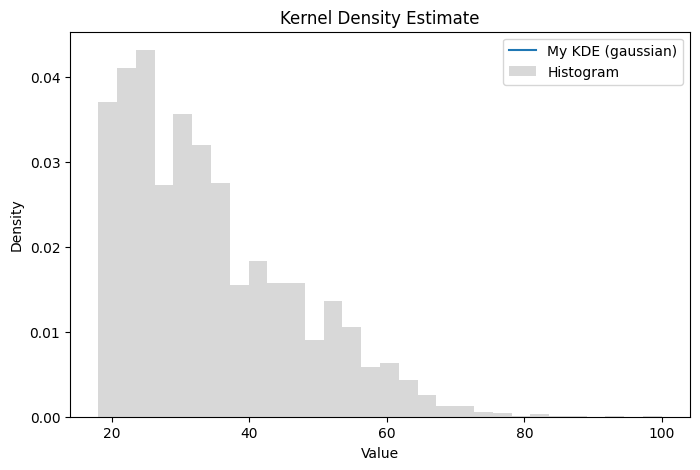

In [60]:
url = 'https://raw.githubusercontent.com/hildj/visualization_assignment/refs/heads/main/data/pretrial_data.csv'
pretrial_data = pd.read_csv(url)

data = pretrial_data['age']

x_grid, kde_values = my_kde(data, kernel='gaussian')

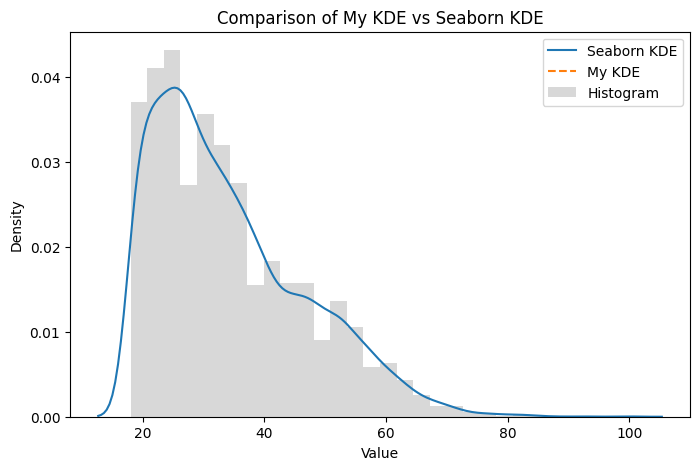

In [61]:
import seaborn as sea

plt.figure(figsize=(8,5))
sea.kdeplot(data, bw_method='silverman', label='Seaborn KDE')
plt.plot(x_grid, kde_values, label='My KDE', linestyle='--')
plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label='Histogram')
plt.title('Comparison of My KDE vs Seaborn KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

#The KDE plot I made with my own function looks pretty similar to seaborn’s kdeplot, but seaborn’s version comes out a bit smoother and runs faster. The custom one is nice because it shows more clearly how the calculations work, even if it’s not as polished.

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [35]:
#2. What are the dimensions of the data? How many observations are there? What are the variables included? Use .head() to examine the first few rows of data.
#The data contain 3,798 observations and 64 variables. Relevant variables include level (2-year or 4-year), control (Public, Private not-for-profit, Private for-profit), aid_value (average student aid), and grad_100_value (percent graduating on time). The first few rows show these variables are populated across institutions.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/hildj/visualization_assignment/refs/heads/main/data/college_completion.csv'

df = pd.read_csv(url)

print("Dimensions (rows, columns):", df.shape)

print(df.head())

print("Columns:", df.columns.tolist())


Dimensions (rows, columns): (3798, 63)
   index  unitid                            chronname        city    state  \
0      0  100654               Alabama A&M University      Normal  Alabama   
1      1  100663  University of Alabama at Birmingham  Birmingham  Alabama   
2      2  100690                   Amridge University  Montgomery  Alabama   
3      3  100706  University of Alabama at Huntsville  Huntsville  Alabama   
4      4  100724             Alabama State University  Montgomery  Alabama   

    level                 control  \
0  4-year                  Public   
1  4-year                  Public   
2  4-year  Private not-for-profit   
3  4-year                  Public   
4  4-year                  Public   

                                               basic hbcu flagship  ...  \
0  Masters Colleges and Universities--larger prog...    X      NaN  ...   
1  Research Universities--very high research acti...  NaN      NaN  ...   
2            Baccalaureate Colleges--Arts & 

In [37]:
#3. Cross tabulate control and level. Describe the patterns you see.

# The cross-tabulation shows that most 2-year institutions are public (926), followed by private for-profit (465) and private not-for-profit (68). Most 4-year institutions are private not-for-profit (1,180), followed by public (632) and private for-profit (527). Public schools dominate at the 2-year level, while private not-for-profit dominate at the 4-year level.

In [38]:
cross_tab = pd.crosstab(df['control'], df['level'])
print(cross_tab)




level                   2-year  4-year
control                               
Private for-profit         465     527
Private not-for-profit      68    1180
Public                     926     632


In [31]:
# 4. For grad_100_value, create a histogram, kernel density plot, boxplot, and statistical description.
#The grad_100_value ranges from 0% to 100%, with a mean of 28.36% and median of 22.5%. The histogram and kernel density plot show a concentration at low graduation rates with a long tail toward higher rates. The boxplot confirms high variability and several outliers.

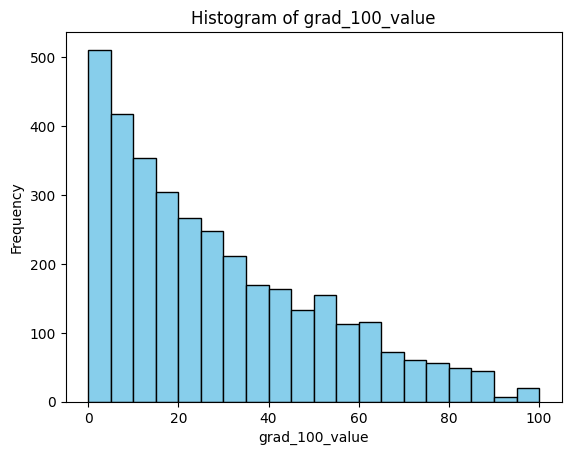

/tmp/ipython-input-8599700.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['grad_100_value'].dropna(), shade=True)


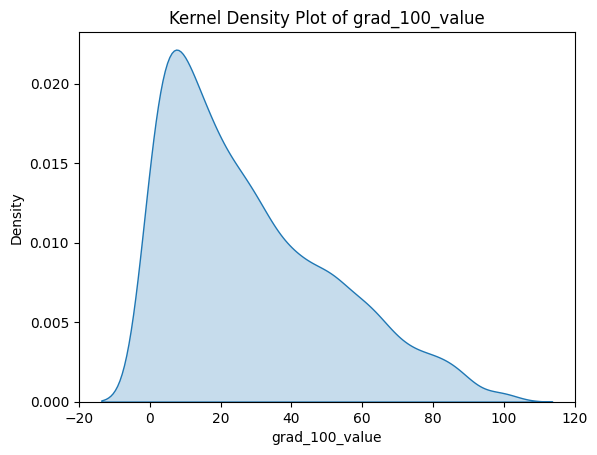

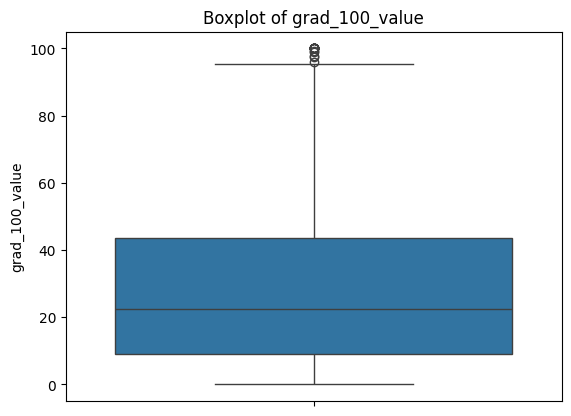

count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


In [39]:
# Histogram
plt.hist(df['grad_100_value'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of grad_100_value')
plt.xlabel('grad_100_value')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Plot
sns.kdeplot(df['grad_100_value'].dropna(), shade=True)
plt.title('Kernel Density Plot of grad_100_value')
plt.show()

# Boxplot
sns.boxplot(y=df['grad_100_value'])
plt.title('Boxplot of grad_100_value')
plt.show()

# Statistical Description
print(df['grad_100_value'].describe())


In [34]:
#5. For grad_100_value, create a grouped kernel density plot by control and by level. Describe what you see. Use groupby and .describe to make grouped calculations of statistical descriptions of grad_100_value by level and control. Which institutions appear to have the best graduation rates?
# Based on this data, private not-for-profit schools have the highest graduation rates (mean 41.7%, median 41%), private for-profit schools are intermediate (mean 29.1%, median 24.7%), and public schools have the lowest (mean 17.4%, median 13.2%). Four-year schools outperform 2-year schools (mean 33.2% vs 21.6%, median 29.7% vs 13%). The best graduation rates occur at 4-year private not-for-profit institutions.

/tmp/ipython-input-401395275.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='grad_100_value', hue='control', shade=True)


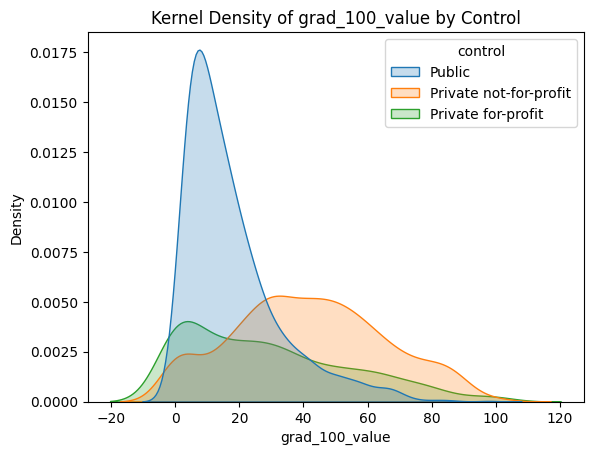

/tmp/ipython-input-401395275.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='grad_100_value', hue='level', shade=True)


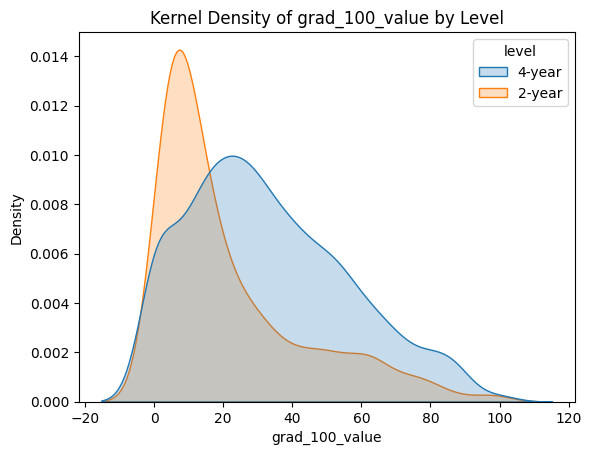

Grouped by control:
                          count       mean        std  min    25%   50%    75%  \
control                                                                         
Private for-profit       779.0  29.108858  25.601687  0.0   6.95  24.7  46.75   
Private not-for-profit  1189.0  41.660976  23.551231  0.0  25.00  41.0  58.30   
Public                  1499.0  17.430887  14.729443  0.0   6.90  13.2  23.25   

                          max  
control                        
Private for-profit      100.0  
Private not-for-profit  100.0  
Public                   97.8  

Grouped by level:
          count       mean        std  min   25%   50%     75%    max
level                                                               
2-year  1455.0  21.636151  21.645747  0.0   6.0  13.0  30.600  100.0
4-year  2012.0  33.230119  23.270160  0.0  15.2  29.7  49.225  100.0


In [40]:
# By control
sns.kdeplot(data=df, x='grad_100_value', hue='control', shade=True)
plt.title('Kernel Density of grad_100_value by Control')
plt.show()

# By level
sns.kdeplot(data=df, x='grad_100_value', hue='level', shade=True)
plt.title('Kernel Density of grad_100_value by Level')
plt.show()

# Grouped statistical description
grouped_stats_control = df.groupby('control')['grad_100_value'].describe()
grouped_stats_level = df.groupby('level')['grad_100_value'].describe()
print("Grouped by control:\n", grouped_stats_control)
print("\nGrouped by level:\n", grouped_stats_level)


In [41]:
#6. Create a new variable, df['levelXcontrol']=df['level']+', '+df['control'] that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
#The levelXcontrol variable combines level and control. Grouped kernel density plots and descriptive statistics show that 4-year private not-for-profit schools have the highest graduation rates, followed by 2-year private not-for-profit schools. 2-year public schools have the lowest rates.

/tmp/ipython-input-612940633.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='grad_100_value', hue='levelXcontrol', shade=True)


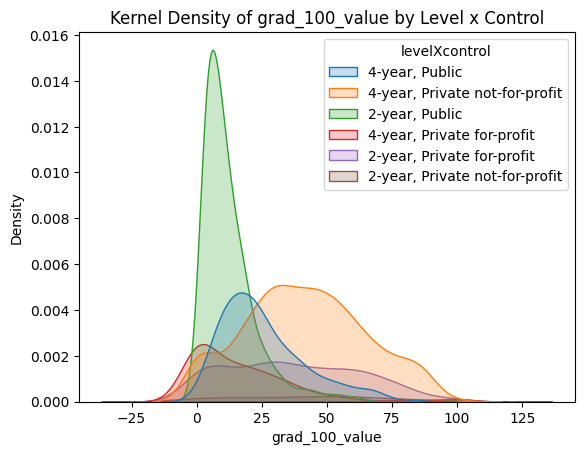

                                 count       mean        std  min     25%  \
levelXcontrol                                                               
2-year, Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
2-year, Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
2-year, Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year, Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
4-year, Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
4-year, Public                   573.0  25.561082  16.403902  0.0  13.600   

                                 50%     75%    max  
levelXcontrol                                        
2-year, Private for-profit      33.9  57.800  100.0  
2-year, Private not-for-profit  44.4  61.200  100.0  
2-year, Public                   9.4  16.175   97.8  
4-year, Private for-profit      12.5  26.325  100.0  
4-year, Private not-for-profit  41.0  57.800  100.0  
4-yea

In [42]:
df['levelXcontrol'] = df['level'] + ', ' + df['control']

sns.kdeplot(data=df, x='grad_100_value', hue='levelXcontrol', shade=True)
plt.title('Kernel Density of grad_100_value by Level x Control')
plt.show()

# Grouped statistical description
grouped_stats_levelXcontrol = df.groupby('levelXcontrol')['grad_100_value'].describe()
print(grouped_stats_levelXcontrol)


In [43]:
# 7. Make a kernel density plot of aid_value. Now group your graph by level and control. What explains the shape of the graph? Use groupby and .describe to make grouped calculations of statistical descriptions of aid_value by level and control.
#The aid_value distribution is right-skewed, with most institutions offering low aid and a few offering very high aid. Four-year schools provide higher aid than 2-year schools. Private not-for-profit institutions offer the highest average aid ($14,181), followed by public ($5,095) and private for-profit ($4,632). The shape reflects high aid concentrated among 4-year private not-for-profit schools.

/tmp/ipython-input-1354016549.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['aid_value'].dropna(), shade=True)


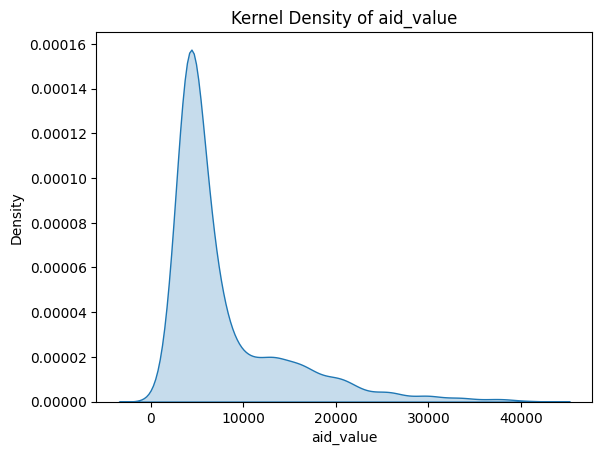

/tmp/ipython-input-1354016549.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='aid_value', hue='level', shade=True)


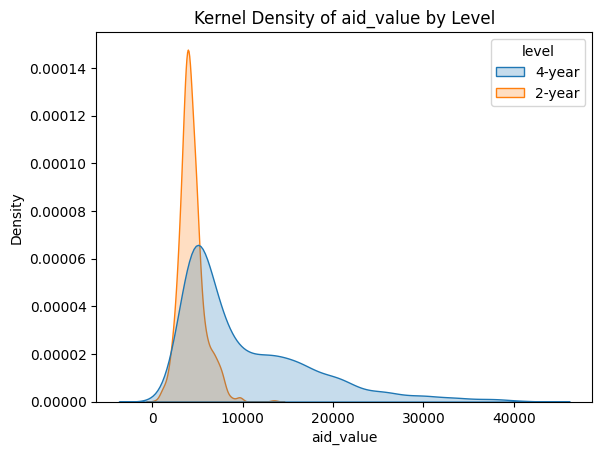

/tmp/ipython-input-1354016549.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='aid_value', hue='control', shade=True)


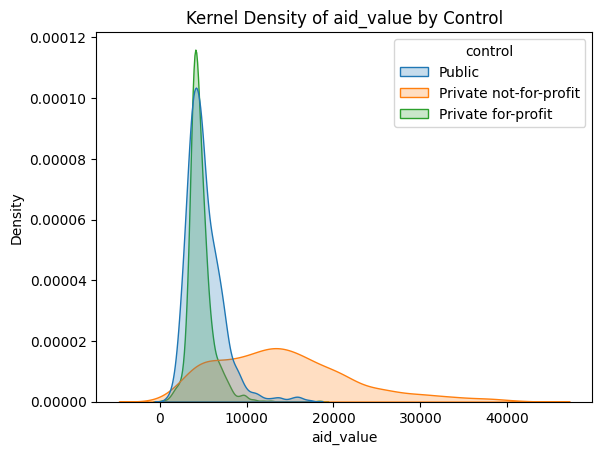

Grouped aid_value by level:
          count          mean          std    min     25%     50%      75%  \
level                                                                       
2-year  1458.0   4310.878601  1384.045631  294.0  3485.5  4113.0   4890.0   
4-year  2339.0  10235.379222  7227.369167  902.0  4830.5  7222.0  14046.0   

            max  
level            
2-year  13654.0  
4-year  41580.0  

Grouped aid_value by control:
                          count          mean          std    min      25%  \
control                                                                     
Private for-profit       991.0   4632.206862  1399.121259  294.0  3861.50   
Private not-for-profit  1248.0  14180.722756  7772.700998  902.0  8325.00   
Public                  1558.0   5094.835687  2136.436370  881.0  3725.25   

                            50%      75%      max  
control                                            
Private for-profit       4331.0   5131.5  18355.0  
Private not-for-

In [44]:
# Overall KDE
sns.kdeplot(df['aid_value'].dropna(), shade=True)
plt.title('Kernel Density of aid_value')
plt.show()

# Grouped KDE by level
sns.kdeplot(data=df, x='aid_value', hue='level', shade=True)
plt.title('Kernel Density of aid_value by Level')
plt.show()

# Grouped KDE by control
sns.kdeplot(data=df, x='aid_value', hue='control', shade=True)
plt.title('Kernel Density of aid_value by Control')
plt.show()

# Grouped statistical descriptions
grouped_aid_stats_level = df.groupby('level')['aid_value'].describe()
grouped_aid_stats_control = df.groupby('control')['aid_value'].describe()
print("Grouped aid_value by level:\n", grouped_aid_stats_level)
print("\nGrouped aid_value by control:\n", grouped_aid_stats_control)


In [45]:
#8. Make a scatterplot of grad_100_value by aid_value. Describe what you see. Now make the same plot, grouping by level and then control. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?
#Graduation rates moderately increase with aid (correlation 0.576). Four-year schools cluster at higher aid and graduation rates compared to 2-year schools. Private not-for-profit institutions generally show both high aid and high graduation rates, while public and private for-profit schools have lower values. Aid appears to increase graduation rates mostly at 4-year private not-for-profit institutions.

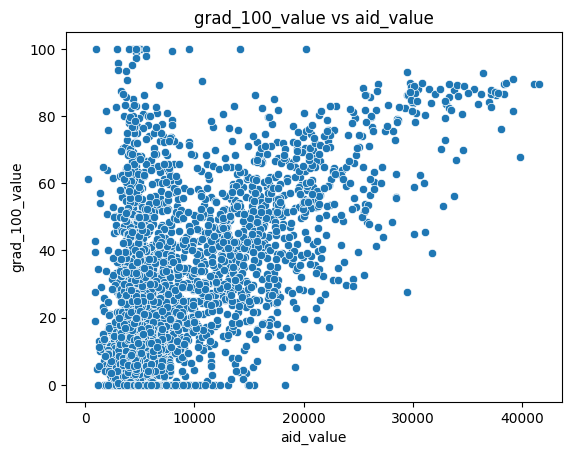

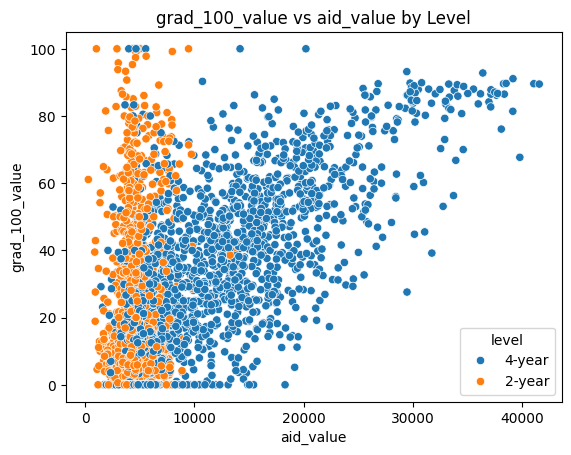

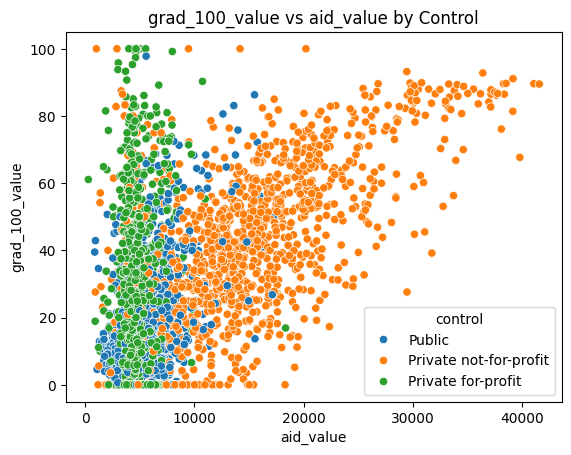

In [46]:
# Overall
sns.scatterplot(x='aid_value', y='grad_100_value', data=df)
plt.title('grad_100_value vs aid_value')
plt.show()

# Grouped by level
sns.scatterplot(x='aid_value', y='grad_100_value', hue='level', data=df)
plt.title('grad_100_value vs aid_value by Level')
plt.show()

# Grouped by control
sns.scatterplot(x='aid_value', y='grad_100_value', hue='control', data=df)
plt.title('grad_100_value vs aid_value by Control')
plt.show()
